# Wire Length Estimation via Signal Superposition

## Setup

A signal generator outputs a square wave that is fed into a splitter:
- **Path A (direct):** splitter → SDR
- **Path B (reflected):** splitter → wire → radio dish transmitter → (reflects back) → SDR

The SDR measures the superposition of both paths. The reflected signal arrives with a
round-trip time delay of
$$\tau = \frac{2L}{v}$$
where $L$ is the wire length and $v = \xi c$ is the propagation speed in the coaxial
cable ($\xi \approx 0.66$ for RG-58).

By identifying $\tau$ from the superposed signal we can recover $L = v\tau/2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlation_lags

## Parameters

In [2]:
# Physical constants
c = 3e8                  # speed of light, m/s
velocity_factor = 0.7   # RG-58 coaxial cable
v_wire = c * velocity_factor

# Experiment parameters
f_sig = 2.5e6   # signal generator frequency, Hz
L_true = 51    # true wire length, m

# Derived
tau = 2 * L_true / v_wire          # round-trip delay, s
phi = 2 * np.pi * f_sig * tau      # accumulated phase, rad
lambda_wire = v_wire / f_sig       # wavelength in wire, m

print(f"Propagation speed:  {v_wire/1e8:.3f} × 10⁸ m/s")
print(f"Wavelength in wire: {lambda_wire:.2f} m")
print(f"Round-trip delay:   {tau*1e9:.2f} ns")
print(f"Phase accumulated:  {np.degrees(phi):.1f}°  ({phi/np.pi:.3f}π)")

Propagation speed:  2.100 × 10⁸ m/s
Wavelength in wire: 84.00 m
Round-trip delay:   485.71 ns
Phase accumulated:  437.1°  (2.429π)


## Signal Generation

A square wave at frequency $f$ is represented by its Fourier series (odd harmonics only):

$$s(t) = \frac{4}{\pi} \sum_{\substack{n=1,3,5,\ldots \\ n \leq N}} \frac{1}{n} \sin(2\pi n f t)$$

We include all odd harmonics up to the Nyquist frequency $f_s/2$.

In [3]:
fs = 100e6          # simulation sample rate, Hz
n_periods = 5      # number of periods to simulate
t = np.arange(0, n_periods / f_sig, 1 / fs)

# Odd harmonics up to the Nyquist frequency
harmonics = range(1, 50, 2)
print(f"Using {len(list(harmonics))} harmonics: "
      f"n = 1, 3, ..., {max(harmonics)}")

def square_wave(t, f, harmonics):
    return sum(
        (4 / np.pi) * (1 / n) * np.sin(2 * np.pi * n * f * t)
        for n in harmonics
    )

# Direct path: splitter → SDR
s_direct = square_wave(t, f_sig, harmonics)

# Reflected path: splitter → wire (100 m) → dish → back → SDR
n_delay = int(np.round(tau * fs))
s_reflected = np.zeros_like(s_direct)
s_reflected[n_delay:] = s_direct[:-n_delay]

# Superposed signal measured by the SDR
s_sdr = s_direct + s_reflected

print(f"Delay in samples: {n_delay}  ({n_delay/fs*1e9:.2f} ns)")

Using 25 harmonics: n = 1, 3, ..., 49
Delay in samples: 49  (490.00 ns)


## Time-Domain Visualisation

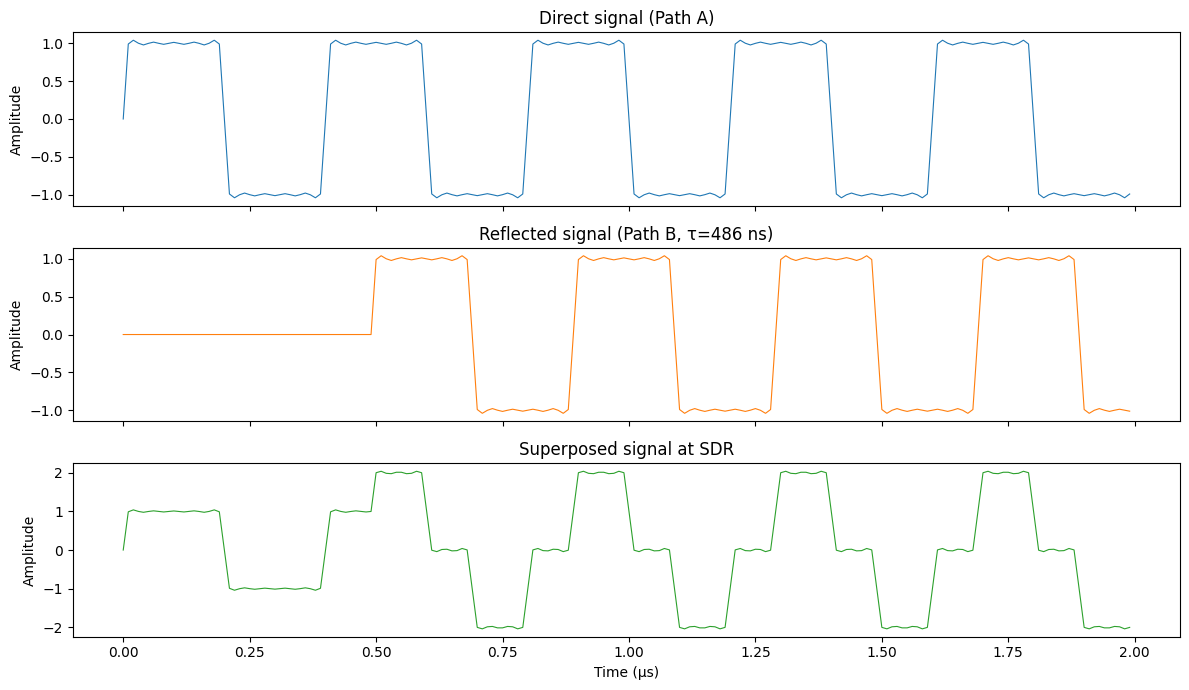

In [4]:
t_us = t * 1e6   # µs for plotting

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

axes[0].plot(t_us, s_direct, lw=0.8, color='C0')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Direct signal (Path A)')

axes[1].plot(t_us, s_reflected, lw=0.8, color='C1')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Reflected signal (Path B, τ={tau*1e9:.0f} ns)')

axes[2].plot(t_us, s_sdr, lw=0.8, color='C2')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time (µs)')
axes[2].set_title('Superposed signal at SDR')

plt.tight_layout()
plt.show()